
# Recipe Review Ratings Prediction – Analysis Notebook

**Author:** Fatema_Islam_Surovi
 **Date:** 2025-09-15
## Project Roadmap

1. Import & Setup  
2. Load Data  
3. Data Cleaning  
4. Exploratory Data Analysis (EDA)  
5. Feature Engineering  
6. Modeling: Logistic Regression & Random Forest (class‑balanced)  
7. Evaluation (reports, confusion matrix, ROC‑AUC)  
8. Feature Importance  
9. Insights & Next Steps


In [ ]:
import os, random, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

# Quality-of-life
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)
SEED = 42
random.seed(SEED); np.random.seed(SEED)

pd.set_option("display.max_columns", 100)
print("Libraries imported. Seed set =", SEED)


Libraries imported. Seed set = 42


## 2. Load Data

In [ ]:
DATA_PATH = "recipe_reviews.csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head(3))


Shape: (18182, 24)


,Unnamed: 0,recipe_number,recipe_code,likes_score,dislike_index,response_level,user_index,ranking_value,vote_ratio,score_log,region,device_type,recipe_name,comment_id,user_id,user_name,user_score,created_at,responses,likes,dislikes,ranking_score,text,stars
0,0,1,14299,0.104335,-0.087082,-0.001580,1.172032,539.698328,0.000,0.693147,North,Tablet,Creamy White Chili,sp_aUSaElGf_14299_c_2G3aneMRgRMZwXqIHmSdXSG1hEM,u_9iFLIhMa8QaG,Jeri326,1,1665619889,0,0,0,527,"I tweaked it a little, removed onions because ...",5
1,1,1,14299,6.970958,-0.094496,-0.002169,50.629458,720.511995,0.875,3.931826,West,Mobile,Creamy White Chili,sp_aUSaElGf_14299_c_2FsPC83HtzCsQAtOxlbL6RcaPbY,u_Lu6p25tmE77j,Mark467,50,1665277687,0,7,0,724,Bush used to have a white chili bean and it ma...,5
2,2,1,14299,3.136047,-0.047194,0.014539,10.742998,717.194563,0.750,2.397895,North,Desktop,Creamy White Chili,sp_aUSaElGf_14299_c_2FPrSGyTv7PQkZq37j92r9mYGkP,u_s0LwgpZ8Jsqq,Barbara566,10,1664404557,0,3,0,710,I have a very complicated white chicken chili ...,5



## 3. Data Cleaning

- Replace placeholder `'2'` inside *text* columns with `NaN` (per instructions).  
- Drop duplicates.  
- Convert `created_at` to datetime (if it looks like unix seconds).  
- Remove **0‑star** rows (no actual rating given).  
- Drop irrelevant IDs and purely descriptive columns that won't help a generalizable model.


In [ ]:
df_raw = df.copy()
# Replace '2' placeholders in text columns with NaN
obj_cols = df_raw.select_dtypes(include='object').columns
df_raw[obj_cols] = df_raw[obj_cols].replace('2', np.nan)
#Drop duplicates
before = len(df_raw)
df_raw = df_raw.drop_duplicates()
print("Duplicates removed:", before - len(df_raw))
#Convert created_at to datetime
if 'created_at' in df_raw.columns:
    try:
        dt = pd.to_datetime(df_raw['created_at'], unit='s', errors='coerce')
        if dt.isna().mean() > 0.9:
            dt = pd.to_datetime(df_raw['created_at'], errors='coerce')
        df_raw['created_at'] = dt
    except Exception as e:
        print("created_at parse skipped:", e)
#Remove 0-star rows
if 'stars' in df_raw.columns and pd.api.types.is_numeric_dtype(df_raw['stars']):
    zero_star = (df_raw['stars'] == 0).sum()
    if zero_star:
        print("0-star rows removed:", zero_star)
        df_raw = df_raw[df_raw['stars'] != 0]
#Drop irrelevant/ID columns
cols_to_drop = [
    'Unnamed: 0', 'recipe_number', 'recipe_code', 'recipe_name',
    'comment_id', 'user_id', 'user_name'
]
df = df_raw.drop(columns=[c for c in cols_to_drop if c in df_raw.columns], errors='ignore')
#Final check
print("Shape after cleaning:", df.shape)
display(df.head(3))


Duplicates removed: 0
Shape after cleaning: (16486, 17)


,likes_score,dislike_index,response_level,user_index,ranking_value,vote_ratio,score_log,region,device_type,user_score,created_at,responses,likes,dislikes,ranking_score,text,stars
0,0.104335,-0.087082,-0.001580,1.172032,539.698328,0.000,0.693147,North,Tablet,1,2022-10-13 00:11:29,0,0,0,527,"I tweaked it a little, removed onions because ...",5
1,6.970958,-0.094496,-0.002169,50.629458,720.511995,0.875,3.931826,West,Mobile,50,2022-10-09 01:08:07,0,7,0,724,Bush used to have a white chili bean and it ma...,5
2,3.136047,-0.047194,0.014539,10.742998,717.194563,0.750,2.397895,North,Desktop,10,2022-09-28 22:35:57,0,3,0,710,I have a very complicated white chicken chili ...,5



## 4. Exploratory Data Analysis (EDA)

We’ll check distributions and simple relationships, keeping charts clear and readable.


Star counts:
 stars
1      280
2      232
3      490
4     1655
5    13829
Name: count, dtype: int64


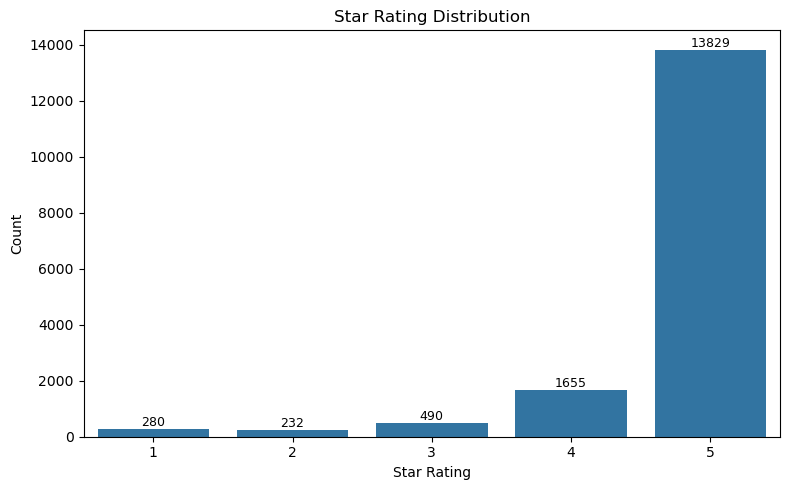

In [ ]:
if 'df' in globals():
    if 'stars' in df.columns:
        rating_counts = df['stars'].value_counts().sort_index()
        print("Star counts:\n", rating_counts)

        plt.figure(figsize=(8,5))
        ax = sns.barplot(x=rating_counts.index.astype(str), y=rating_counts.values)
        plt.title("Star Rating Distribution")
        plt.xlabel("Star Rating")
        plt.ylabel("Count")

        # Add value labels
        for i, v in enumerate(rating_counts.values):
            ax.text(i, v, str(v), ha='center', va='bottom', fontsize=9)
        plt.tight_layout()
        plt.show()
    else:
        print("Column `stars` not found.")
else:
    print("Load the data first.")


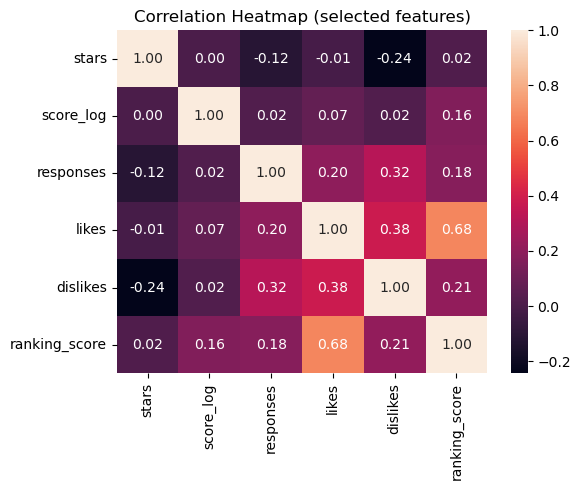

In [ ]:
if 'df' in globals():
    num_cols = [c for c in ['stars','score_log','responses','likes','dislikes','ranking_score'] if c in df.columns]
    if len(num_cols) >= 2:
        corr = df[num_cols].corr(numeric_only=True)
        plt.figure(figsize=(6,5))
        sns.heatmap(corr, annot=True, fmt=".2f")
        plt.title("Correlation Heatmap (selected features)")
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough numeric columns for a heatmap.")
else:
    print("Load the data first.")


In [ ]:
if 'df' in globals():
    needed = {'likes','dislikes','stars'}
    if needed.issubset(set(df.columns)):
        # basic subsample for performance if huge
        dfx = df.sample(min(5000, len(df)), random_state=42) if len(df) > 5000 else df.copy()
        fig = px.scatter(dfx, x="likes", y="dislikes", color=dfx['stars'].astype(str),
                         title="Interactive: Likes vs Dislikes (colored by stars)")
        fig.show()
    else:
        print("Need columns likes, dislikes, stars for this interactive plot.")
else:
    print("Load the data first.")



## 5. Feature Engineering

- Select predictive features  
- One‑hot encode categoricals (`region`, `device_type` if present)  
- Standardize numeric features for Logistic Regression


In [34]:

if 'df' in globals():
    target = 'stars'
    base_features = []
    # Add columns if they exist
    for c in ['score_log','responses','likes','dislikes','ranking_score','region','device_type']:
        if c in df.columns:
            base_features.append(c)

    if target not in df.columns:
        raise ValueError("Target column `stars` is missing. Please check your CSV.")

    X = df[base_features].copy()
    y = df[target].copy()

    print("Features used:", list(X.columns))
    # Identify numeric/categorical
    numeric_features = [c for c in ['score_log','responses','likes','dislikes','ranking_score'] if c in X.columns]
    categorical_features = [c for c in ['region','device_type'] if c in X.columns]

    display(X.head(3))


Features used: ['score_log', 'responses', 'likes', 'dislikes', 'ranking_score', 'region', 'device_type']


,score_log,responses,likes,dislikes,ranking_score,region,device_type
0,0.693147,0,0,0,527,North,Tablet
1,3.931826,0,7,0,724,West,Mobile
2,2.397895,0,3,0,710,North,Desktop



## 6. Modeling

We train two models with **class‑balanced** weights:

- **Multinomial Logistic Regression**  
- **Random Forest Classifier**


In [ ]:

if 'df' in globals():
# Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y if y.nunique() > 1 else None
    )
# Preprocessors
    num_t = Pipeline([('scaler', StandardScaler())]) if len(numeric_features) else 'passthrough'
    cat_t = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))]) if len(categorical_features) else 'passthrough'
    preprocessor = ColumnTransformer([
        ('num', num_t, numeric_features),
        ('cat', cat_t, categorical_features)
    ])

    logistic_pipeline = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        solver='lbfgs',
        random_state=0
    ))
])
    rf_pipeline = Pipeline([
        ('prep', preprocessor),
        ('clf', RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=0))
    ])

    logistic_pipeline.fit(X_train, y_train)#fit
    rf_pipeline.fit(X_train, y_train)

    print("Models trained.")

Models trained.



## 7. Evaluation
We report classification metrics and confusion matrices for both models.


=== Logistic Regression ===
              precision    recall  f1-score   support

           1      0.233     0.304     0.264        56
           2      0.020     0.217     0.037        46
           3      0.033     0.031     0.032        98
           4      0.116     0.148     0.130       331
           5      0.863     0.690     0.767      2767

    accuracy                          0.603      3298
   macro avg      0.253     0.278     0.246      3298
weighted avg      0.741     0.603     0.662      3298


=== Random Forest ===
              precision    recall  f1-score   support

           1      0.116     0.179     0.141        56
           2      0.071     0.130     0.092        46
           3      0.049     0.082     0.061        98
           4      0.084     0.172     0.113       331
           5      0.844     0.696     0.763      2767

    accuracy                          0.608      3298
   macro avg      0.233     0.252     0.234      3298
weighted avg      0.721   

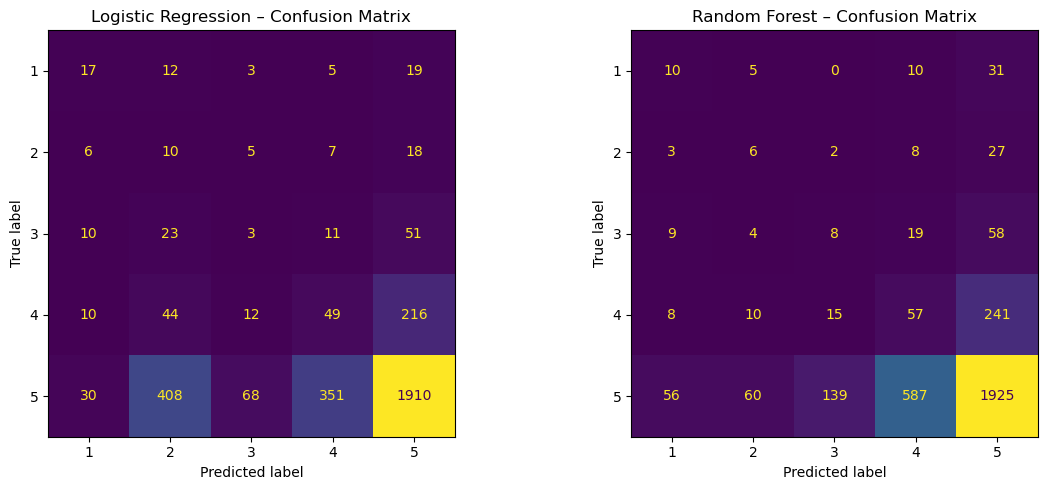

Macro ROC-AUC -> Logistic: 0.588 | RandomForest: 0.512


In [32]:

from sklearn.metrics import classification_report

if 'df' in globals():
    # Predictions
    y_pred_log = logistic_pipeline.predict(X_test)
    y_pred_rf  = rf_pipeline.predict(X_test)

    print("=== Logistic Regression ===")
    print(classification_report(y_test, y_pred_log, digits=3))
    print("\n=== Random Forest ===")
    print(classification_report(y_test, y_pred_rf, digits=3))

    # Confusion matrices
    labels = sorted(y.unique())
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log, labels=labels, ax=axes[0], colorbar=False)
    axes[0].set_title("Logistic Regression – Confusion Matrix")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, labels=labels, ax=axes[1], colorbar=False)
    axes[1].set_title("Random Forest – Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Macro AUC
    try:
        from sklearn.preprocessing import label_binarize
        classes = np.array(labels)
        y_test_bin = label_binarize(y_test, classes=classes)

        # LR
        proba_log = logistic_pipeline.predict_proba(X_test)
        auc_log = roc_auc_score(y_test_bin, proba_log, average='macro', multi_class='ovr')
        # RF
        proba_rf = rf_pipeline.predict_proba(X_test)
        auc_rf = roc_auc_score(y_test_bin, proba_rf, average='macro', multi_class='ovr')
        print(f"Macro ROC-AUC -> Logistic: {auc_log:.3f} | RandomForest: {auc_rf:.3f}")
    except Exception as e:
        print("ROC-AUC skipped:", e)
else:
    print("Load and train models first.")



## 8. Feature Importance (Random Forest)

We inspect the top drivers the tree ensemble used.


dislikes               0.310551
ranking_score          0.202702
likes                  0.133335
score_log              0.097762
responses              0.036328
device_type_Desktop    0.034580
device_type_Mobile     0.034357
device_type_Tablet     0.034309
region_North           0.029653
region_South           0.029511
region_East            0.028461
region_West            0.028452
dtype: float64

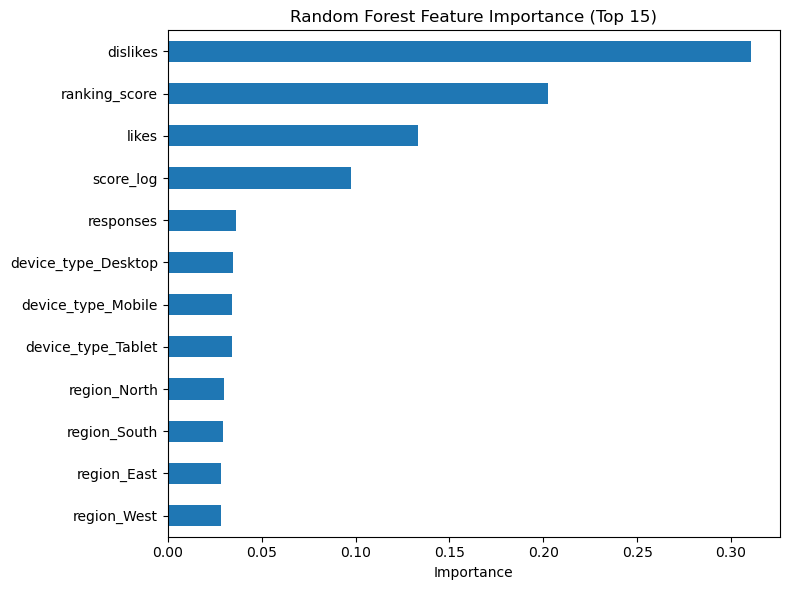

In [33]:

if 'df' in globals():
    rf = rf_pipeline.named_steps['clf']
    prep = rf_pipeline.named_steps['prep']

    # Build featureName list
    feat_names = []
    if len(numeric_features):
        feat_names += numeric_features
    if len(categorical_features):
        oh = prep.named_transformers_['cat']
        if hasattr(oh, 'named_steps'):
            oh_enc = oh.named_steps['onehot']
        else:
            oh_enc = oh
        if hasattr(oh_enc, 'get_feature_names_out'):
            feat_names += list(oh_enc.get_feature_names_out(categorical_features))
        else:
            feat_names += categorical_features

    importances = getattr(rf, "feature_importances_", None)
    if importances is not None and len(importances)==len(feat_names):
        imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)
        display(imp.head(15))

        # Plot
        topk = imp.head(15)
        plt.figure(figsize=(8,6))
        topk[::-1].plot(kind='barh')  # reverse for descending display
        plt.title("Random Forest Feature Importance (Top 15)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()
    else:
        print("Could not compute feature importance (check dimensions).")
else:
    print("Train the Random Forest first.")
